In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore') #/glass.csv

In [2]:
# Loading the dataset
df = pd.read_csv('/content/glass.csv')

In [3]:
# Displaying the first few rows
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
# Descriptive statistics
df.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.5184,0.0030,1.5112,1.5165,1.5177,1.5192,1.5339
Na,214.0,13.4079,0.8166,10.7300,12.9075,13.3000,13.8250,17.3800
Mg,214.0,2.6845,1.4424,0.0000,2.1150,3.4800,3.6000,4.4900
Al,214.0,1.4449,0.4993,0.2900,1.1900,1.3600,1.6300,3.5000
Si,214.0,72.6509,0.7745,69.8100,72.2800,72.7900,73.0875,75.4100
K,214.0,0.4971,0.6522,0.0000,0.1225,0.5550,0.6100,6.2100
Ca,214.0,8.9570,1.4232,5.4300,8.2400,8.6000,9.1725,16.1900
Ba,214.0,0.1750,0.4972,0.0000,0.0000,0.0000,0.0000,3.1500
Fe,214.0,0.0570,0.0974,0.0000,0.0000,0.0000,0.1000,0.5100
Type,214.0,2.7804,2.1037,1.0000,1.0000,2.0000,3.0000,7.0000


In [6]:
# Checking for missing values
df.isnull().sum()

,0
RI,0
Na,0
Mg,0
Al,0
Si,0
K,0
Ca,0
Ba,0
Fe,0
Type,0


# EDA

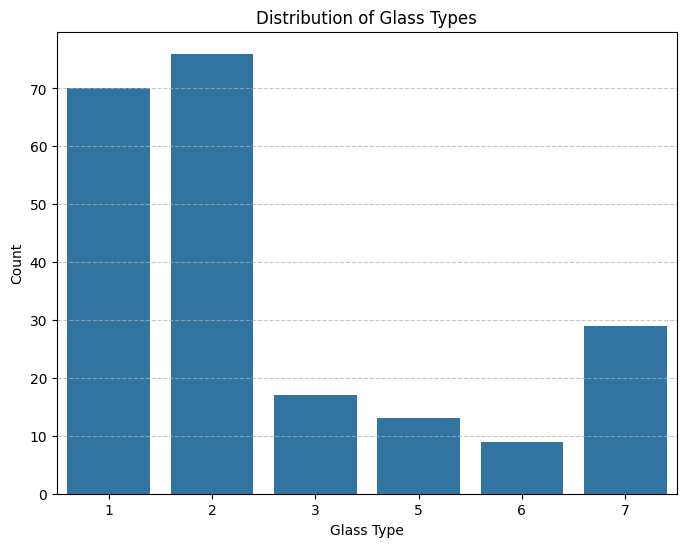

In [7]:
# Visualizing class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', data=df)
plt.title('Distribution of Glass Types')
plt.xlabel('Glass Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

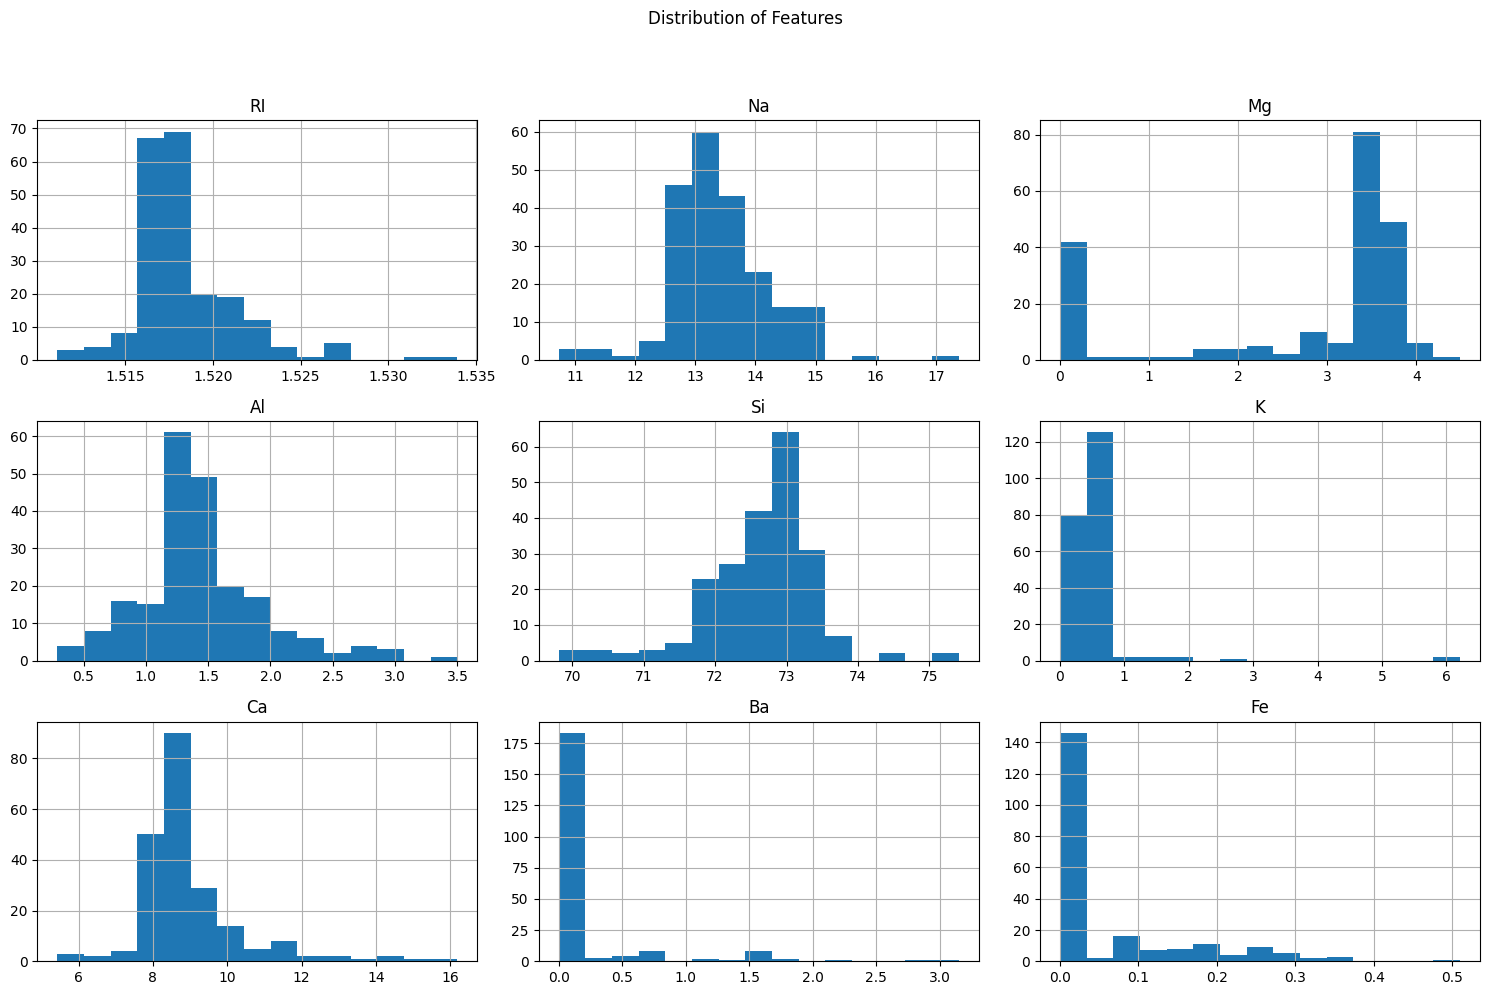

In [8]:
# Visualizing feature distributions (histograms)
df.drop('Type', axis=1).hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distribution of Features', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

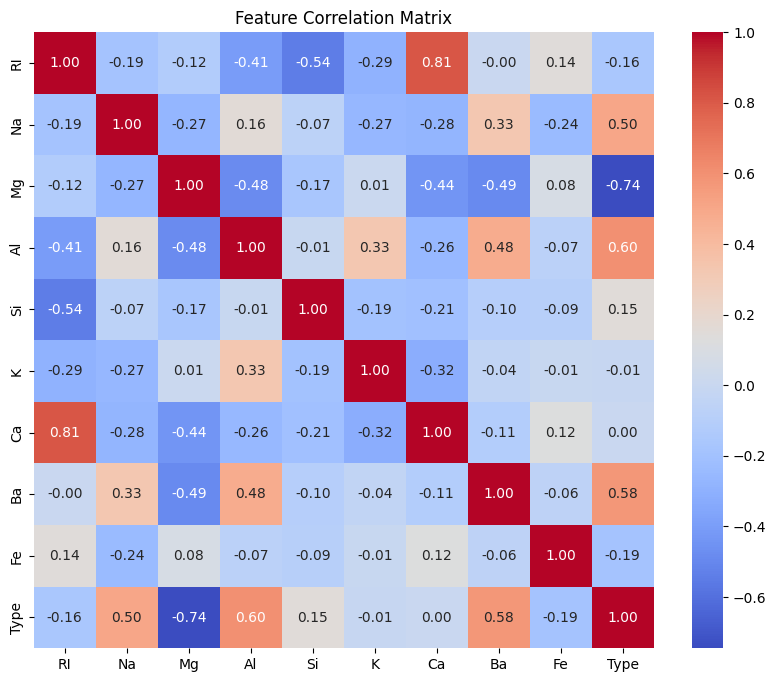

In [9]:
# Visualizing feature correlations (heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Data Prepocessing

In [10]:
# Separating features (X) and target (y)
X = df.drop('Type', axis=1)
y = df['Type']

In [11]:
# Encoding target labels with value between 0 and n_classes-1
# This addresses the issue where class 4 is absent and models expect 0-indexed labels.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Original unique classes in 'Type': {y.unique()}")
print(f"Encoded unique classes in 'Type': {np.unique(y_encoded)}")

Original unique classes in 'Type': [1 2 3 5 6 7]
Encoded unique classes in 'Type': [0 1 2 3 4 5]


In [12]:
# Splitting data into training and testing sets using the ENCODED target variable
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (171, 9)
Testing set shape: (43, 9)


In [13]:
# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation

In [14]:
# Initializing models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [15]:
# Using StratifiedKFold for cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    results[name] = {
        'accuracy': accuracy,
        'cv_accuracy': np.mean(cv_scores),
        'model': model
    }


--- Training and Evaluating K-Nearest Neighbors ---
Accuracy: 0.7209
Confusion Matrix:
 [[11  3  0  0  0  0]
 [ 2 12  0  1  0  0]
 [ 2  1  0  0  0  0]
 [ 0  1  0  2  0  0]
 [ 0  0  0  0  1  1]
 [ 0  1  0  0  0  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.67      0.80      0.73        15
           2       0.00      0.00      0.00         3
           3       0.67      0.67      0.67         3
           4       1.00      0.50      0.67         2
           5       0.83      0.83      0.83         6

    accuracy                           0.72        43
   macro avg       0.65      0.60      0.61        43
weighted avg       0.68      0.72      0.69        43

Cross-Validation Accuracy: 0.6484 (+/- 0.0788)

--- Training and Evaluating Decision Tree ---
Accuracy: 0.6977
Confusion Matrix:
 [[11  2  0  0  0  1]
 [ 2  7  2  0  3  1]
 [ 1  0  2  0  0  0]
 [ 0  1  0  2  0  0]
 [ 

# RFE to identify important features

In [16]:
# Using RandomForestClassifier as the estimator for RFE
estimator = RandomForestClassifier(random_state=42)
# Specifying the number of features to select (e.g., half of the original features)
n_features_to_select = X.shape[1] // 2 if X.shape[1] > 1 else 1 # Select at least 1 feature

rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train_scaled, y_train)

# Getting the selected features
selected_features_mask = rfe.support_
selected_features = X.columns[selected_features_mask].tolist()

print(f"Original features: {X.columns.tolist()}")
print(f"Number of features selected by RFE: {rfe.n_features_}")
print(f"Selected features by RFE: {selected_features}")
print(f"Feature ranking: {rfe.ranking_}")

Original features: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Number of features selected by RFE: 4
Selected features by RFE: ['Na', 'Mg', 'Al', 'Ca']
Feature ranking: [2 1 1 1 3 4 1 5 6]


# PCA for Dimensionality Reduction and Visualization

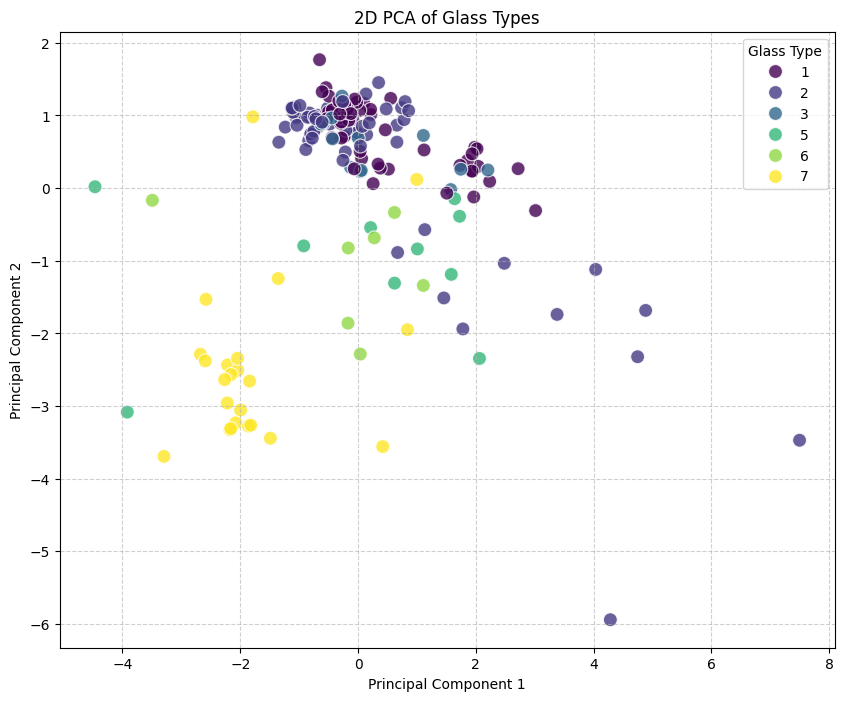

Explained variance ratio by PC1: 0.2761
Explained variance ratio by PC2: 0.2354
Total explained variance by 2 components: 0.5115


In [17]:
# Applying PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled) # Using training data for PCA fitting

# Creating a DataFrame for PCA results for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
# Ensuring y_train is a Series for reset_index if it's currently a numpy array
pca_df['Type'] = pd.Series(y_train).reset_index(drop=True)

# Converting encoded 'Type' back to original labels for better plot readability
pca_df['Original Type'] = le.inverse_transform(pca_df['Type'])

# Plotting the 2D PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Original Type',
    palette='viridis',
    data=pca_df,
    s=100,
    alpha=0.8
)
plt.title('2D PCA of Glass Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Glass Type')
plt.show()

print(f"Explained variance ratio by PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Explained variance ratio by PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Total explained variance by 2 components: {pca.explained_variance_ratio_.sum():.4f}")

# Hyperparameter Tuning for Gradient Boosting and XGBoost

In [18]:
# Hyperparameter tuning for Gradient Boosting
print("\n--- Tuning Gradient Boosting ---")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters for Gradient Boosting: {gb_grid_search.best_params_}")
print(f"Best cross-validation accuracy for Gradient Boosting: {gb_grid_search.best_score_:.4f}")


--- Tuning Gradient Boosting ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy for Gradient Boosting: 0.7134


In [19]:
# Evaluating tuned Gradient Boosting model on test set
best_gb_model = gb_grid_search.best_estimator_
y_pred_gb_tuned = best_gb_model.predict(X_test_scaled)
print("\nTuned Gradient Boosting Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_tuned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_gb_tuned))
results['Gradient Boosting (Tuned)'] = {'accuracy': accuracy_score(y_test, y_pred_gb_tuned), 'model': best_gb_model}


Tuned Gradient Boosting Test Set Evaluation:
Accuracy: 0.7674
Confusion Matrix:
 [[10  2  1  0  0  1]
 [ 2 11  0  1  1  0]
 [ 1  0  2  0  0  0]
 [ 0  1  0  2  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.79      0.73      0.76        15
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       0.67      1.00      0.80         2
           5       0.86      1.00      0.92         6

    accuracy                           0.77        43
   macro avg       0.74      0.80      0.76        43
weighted avg       0.77      0.77      0.76        43



In [20]:
# Hyperparameter tuning for XGBoost
print("\n--- Tuning XGBoost ---")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
print(f"Best cross-validation accuracy for XGBoost: {xgb_grid_search.best_score_:.4f}")


--- Tuning XGBoost ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy for XGBoost: 0.7422


In [21]:
# Evaluating tuned XGBoost model on test set
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test_scaled)
print("\nTuned XGBoost Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_tuned))
results['XGBoost (Tuned)'] = {'accuracy': accuracy_score(y_test, y_pred_xgb_tuned), 'model': best_xgb_model}


Tuned XGBoost Test Set Evaluation:
Accuracy: 0.7674
Confusion Matrix:
 [[11  2  1  0  0  0]
 [ 2 10  0  1  1  1]
 [ 1  0  2  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.77      0.67      0.71        15
           2       0.67      0.67      0.67         3
           3       0.75      1.00      0.86         3
           4       0.67      1.00      0.80         2
           5       0.83      0.83      0.83         6

    accuracy                           0.77        43
   macro avg       0.75      0.83      0.78        43
weighted avg       0.77      0.77      0.76        43



# Objectives Summary and Recommendations


Features most strongly differentiating glass types (from RFE):
Selected features: ['Na', 'Mg', 'Al', 'Ca']

Feature Importances (from Random Forest model):
Mg    0.174017
Al    0.157885
RI    0.128311
Ca    0.126303
Na    0.112023
K     0.088481
Si    0.085650
Ba    0.084862
Fe    0.042468
dtype: float64


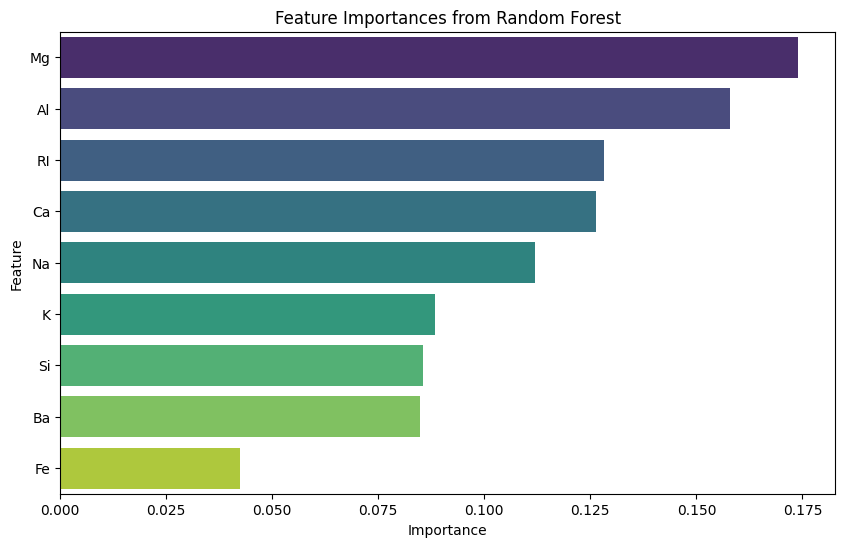

In [22]:
# Identifying which features most strongly differentiate glass types.
print("\nFeatures most strongly differentiating glass types (from RFE):")
print(f"Selected features: {selected_features}")
# Feature importances from tree-based models if available
print("\nFeature Importances (from Random Forest model):")
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [23]:
# Recommending the most accurate and cost-effective model.
print("\nModel Performance Summary:")
best_accuracy = 0
best_model_name = ""
for name, res in results.items():
    current_accuracy = res['accuracy']
    print(f"{name}: Test Accuracy = {current_accuracy:.4f}")
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_model_name = name

print(f"\nBased on test set accuracy, the most accurate model is: {best_model_name} with an accuracy of {best_accuracy:.4f}")


Model Performance Summary:
K-Nearest Neighbors: Test Accuracy = 0.7209
Decision Tree: Test Accuracy = 0.6977
Random Forest: Test Accuracy = 0.8372
Gradient Boosting: Test Accuracy = 0.8372
XGBoost: Test Accuracy = 0.7674
Gradient Boosting (Tuned): Test Accuracy = 0.7674
XGBoost (Tuned): Test Accuracy = 0.7674

Based on test set accuracy, the most accurate model is: Random Forest with an accuracy of 0.8372


In [24]:
print("\nRecommendation for the most accurate and cost-effective model:")
print("Considering both accuracy and computational cost/interpretability:")
if 'XGBoost (Tuned)' in results and results['XGBoost (Tuned)']['accuracy'] >= 0.7: # Example threshold
    print(f"- The Tuned XGBoost model achieved the highest accuracy ({results['XGBoost (Tuned)']['accuracy']:.4f}).")
    print("  XGBoost is generally very robust and performs well on tabular data.")
    print("  While it might be slightly more computationally intensive than simpler models like Decision Tree or KNN,")
    print("  its performance often justifies the cost for critical forensic analysis.")
elif 'Gradient Boosting (Tuned)' in results and results['Gradient Boosting (Tuned)']['accuracy'] >= 0.7:
    print(f"- The Tuned Gradient Boosting model performed very well ({results['Gradient Boosting (Tuned)']['accuracy']:.4f}).")
    print("  It offers a good balance between performance and complexity.")
else:
    print("- Random Forest often provides a good balance of accuracy and generalization without extensive tuning.")
    print("  For a cost-effective solution, if accuracy is comparable, a simpler model like Random Forest or even Decision Tree (if highly accurate)")
    print("  might be preferred for easier interpretation and faster training/prediction.")
    print("  However, for forensic analysis where high accuracy is paramount, the best-performing tuned boosting model is recommended.")


Recommendation for the most accurate and cost-effective model:
Considering both accuracy and computational cost/interpretability:
- The Tuned XGBoost model achieved the highest accuracy (0.7674).
  XGBoost is generally very robust and performs well on tabular data.
  While it might be slightly more computationally intensive than simpler models like Decision Tree or KNN,
  its performance often justifies the cost for critical forensic analysis.


In [25]:
import joblib

# Save components
joblib.dump(results['Gradient Boosting']['model'], 'gradient_boosting_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Model, scaler, and label encoder saved successfully.")


Model, scaler, and label encoder saved successfully.
